In [198]:
"""
Refer to "ForestFireDataAnalysis.ipynb" for data visualization and "ForestFirePredictiveModel" for model
based on previous data.
The dataset used in this file is from another paper and is to be considered seperately from the previous work.

Purpose: create a predictive model for detecting forest fires using a sample of training / testing images
"""

# Data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

In [199]:
# Access directory with testing and training images
import os
testing_directory_path = "/Users/sasha/Desktop/ForestFireDataProject/Forest Fire Dataset/Testing"
training_directory_path = "/Users/sasha/Desktop/ForestFireDataProject/Forest Fire Dataset/Training"


In [200]:
# Image handling library (Pillow)
from PIL import Image
pic = Image.open('Forest Fire Dataset/Training/fire/fire_0003.jpg')

In [209]:
pic_arr = np.asarray(pic)
pic_arr.shape
type(pic_arr)

numpy.ndarray

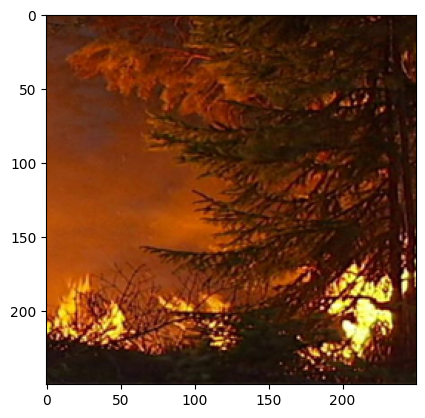

In [210]:
plt.imshow(pic_arr[:,:,:])

In [216]:
# Machine learning libraries
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Parameters for model indicating the amount of images to feed per iteration, image width / height, and random seed
batch_size = 32
img_height = 250
img_width = 250
seed = 123

In [217]:
# Divide data into 80% for training and 20% for testing
# Organize by file structure into seperate classes
train_ds = tf.keras.utils.image_dataset_from_directory(
  testing_directory_path,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  training_directory_path,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)


Found 380 files belonging to 2 classes.
Using 304 files for training.
Found 380 files belonging to 2 classes.
Using 76 files for validation.


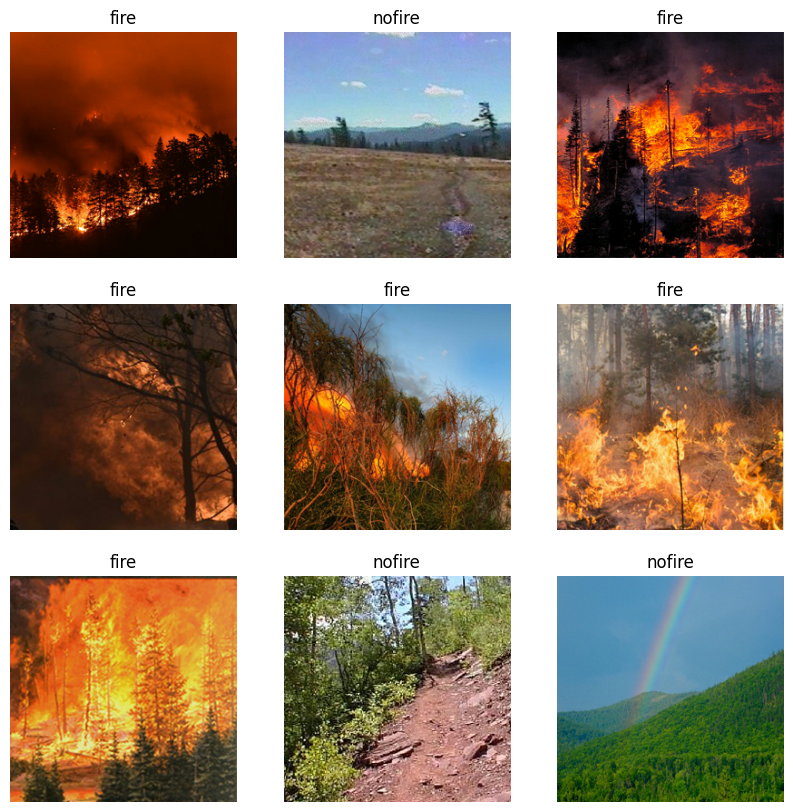

In [219]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [208]:
# Configure dataset for performance with cacheing and prefetching data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [231]:
"""
Linear model for image prediction. Uses the following layers:
    - Rescaling layer - rescales RGB values [1,255] to [0,1] for easier processing
    - 3 Convolution layers - augments doubling amounts of outputs using 3x3 matrix with standard strictly-positive linear function
    - 3 MaxPooling layers - intensifies results found in convolution layers to allow for greater contrast between pixels 
    - Flatten layer - converts multi-dimensional array into a one-dimensional array
    - Dense layer - regular model layer
    - Dense output layer - 2 outputs each representing the chance of fire or no_fire appearing in the image
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale [1,255] range of RGB values to [0,1]
  layers.Conv2D(16, 3, padding='same', activation='relu'), # Apply standard matrix to augment image using rectified linear unit algorithm
  layers.MaxPooling2D(), # For identifying sharp contrasts in fire against background
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), # Flatten multi-dimensional array into a one-dimensional array
  layers.Dense(128, activation='relu'), # Regular layer
  layers.Dense(len(class_names)) # 2 outputs (chance of fire or no_fire)
])

In [233]:
# Compile model with regular Adam optimizer - pruning for accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [234]:
# Brief model summary (before training begins)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 62, 62, 64)       

In [236]:
# Train model for 10 epochs using 
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 3s 266ms/step - loss: 0.0565 - accuracy: 0.9803 - val_loss: 0.1642 - val_accuracy: 0.9474
Epoch 2/10
10/10 [==============================] - 3s 246ms/step - loss: 0.0481 - accuracy: 0.9836 - val_loss: 0.1332 - val_accuracy: 0.9605
Epoch 3/10
10/10 [==============================] - 3s 247ms/step - loss: 0.0348 - accuracy: 0.9934 - val_loss: 0.1394 - val_accuracy: 0.9605
Epoch 4/10
10/10 [==============================] - 3s 247ms/step - loss: 0.0268 - accuracy: 0.9868 - val_loss: 0.1655 - val_accuracy: 0.9605
Epoch 5/10
10/10 [==============================] - 3s 250ms/step - loss: 0.0169 - accuracy: 0.9967 - val_loss: 0.1629 - val_accuracy: 0.9605
Epoch 6/10
10/10 [==============================] - 3s 252ms/step - loss: 0.0140 - accuracy: 0.9967 - val_loss: 0.1624 - val_accuracy: 0.9605
Epoch 7/10
10/10 [==============================] - 3s 250ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9737
Epoch 